In [ ]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
#from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss.replace(0, 1e-6)
    return 100 - (100 / (1 + rs))

def feature_engineering(df):
    from numpy import log, abs
    print("--- Performing Feature Engineering ---")
    if len(df) < 15:
        raise ValueError(f"Dataframe size too small ({len(df)} rows).")

    df_feat = df.copy()

    # Core technicals
    df_feat['rsi_14'] = calculate_rsi(df_feat, window=14)
    df_feat['lag_1'] = df_feat['close'].shift(1)
    df_feat['lag_5'] = df_feat['close'].shift(5)
    df_feat['lag_10'] = df_feat['close'].shift(10)
    df_feat['rolling_mean_5'] = df_feat['close'].rolling(window=5).mean()
    df_feat['rolling_std_5'] = df_feat['close'].rolling(window=5).std()
    df_feat['rolling_mean_10'] = df_feat['close'].rolling(window=10).mean()
    df_feat['rolling_std_10'] = df_feat['close'].rolling(window=10).std()

    # Log return volatility / momentum
    log_return = log(df_feat['close'] / df_feat['close'].shift(1))
    df_feat['volatility_7'] = log_return.rolling(window=7).std()
    df_feat['momentum_5'] = log_return.rolling(window=5).mean()

    # Derived interaction features
    df_feat['high_low_spread'] = df_feat['high'] - df_feat['low']
    df_feat['momentum_x_volume'] = df_feat['momentum_5'] * df_feat['volume']
    df_feat['rsi_sq'] = df_feat['rsi_14'] ** 2
    df_feat['volatility_7_sq'] = df_feat['volatility_7'] ** 2

    # Delta / deviation features
    df_feat['close_delta_5'] = df_feat['close'] - df_feat['close'].shift(5)
    df_feat['log_return_abs'] = abs(log_return)
    df_feat['high_low_vol_ratio'] = df_feat['high_low_spread'] / (df_feat['rolling_std_10'] + 1e-6)

    # Adaptive rolling signals (EWMA)
    df_feat['ewma_5'] = df_feat['close'].ewm(span=5, adjust=False).mean()
    df_feat['ewma_10'] = df_feat['close'].ewm(span=10, adjust=False).mean()
    df_feat['ewma_ratio'] = df_feat['ewma_5'] / (df_feat['ewma_10'] + 1e-6)

    # Day of week effect
    df_feat['day_of_week'] = df_feat['merge_date'].dt.dayofweek

    return df_feat

df = pd.read_csv(r'C:\Users\baile\Documents\Artificial Intelligence\BitcoinPred\standalone_training\bitcoin_sentiment_12012022_11082025.csv')
df['target'] = df['close'].shift(-1)
df['merge_date'] = pd.to_datetime(df['merge_date'], errors='coerce')
df = feature_engineering(df)

# --- 1. Define Features ---
# The 'close' column is now a feature, not the target.
# We must exclude the new 'target' column from the features.
features = [col for col in df.columns if col not in ['merge_date', 'datetime_utc', 'timestamp', 'target'] and 'unnamed' not in col]

# --- 2. Clean Data ---
# Define the columns that MUST NOT have NaNs for training
required_cols = [col for col in df.columns if col not in ['merge_date', 'datetime_utc', 'timestamp', 'unnamed'] and 'unnamed' not in col]
required_cols.append('target') # Ensure the new target is included

# Drop rows based on the required columns
data_clean = df.dropna(subset=required_cols).reset_index(drop=True)

# Check the result after cleaning
if data_clean.empty:
    raise ValueError("The dataset is empty after dropping NaNs. Check your feature engineering steps for excessive NaN creation!")

X = data_clean[features]
y = data_clean['target'] # Use the new 'target' column

# --- 3. Split and Train ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


selected_features = ['lag_10', 'rolling_mean_10', 'low', 'close', 'high',
       'rolling_mean_5', 'open', 'lag_1', 'lag_5']

X_train = X_train[selected_features]   
X_test = X_test[selected_features]
features = selected_features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
########################

print("--- Training and Evaluating Models ---")
results = {}


# 4. Train ML Models
mlr_model = LinearRegression().fit(X_train_scaled, y_train)
ridge_model = Ridge(alpha=0.5, random_state=42).fit(X_train_scaled, y_train)
rf_model = RandomForestRegressor(n_estimators=600, random_state=42).fit(X_train_scaled, y_train)
xgb_model = xgb.XGBRegressor(colsample_bytree=1.0, learning_rate=0.03, max_depth= 7,n_estimators=1200, subsample = 0.9,
                             objective='reg:squarederror', random_state=42).fit(X_train_scaled, y_train)

# Train Auto-ARIMA on the training data for a fair comparison
#arima_model = ARIMA(y_train, order=(1,1,3))
#arima_model_fit = arima_model.fit()

# Evaluate Models
mlr_preds = mlr_model.predict(X_test_scaled)
ridge_preds = ridge_model.predict(X_test_scaled)
rf_preds = rf_model.predict(X_test_scaled)
xgb_preds = xgb_model.predict(X_test_scaled)
linear_residuals = y_train - mlr_model.predict(X_train_scaled)
residual_model = xgb.XGBRegressor(
    learning_rate=0.03, max_depth=7, n_estimators=800, subsample=0.9,
    colsample_bytree=0.9, objective='reg:squarederror', random_state=42
)
residual_model.fit(X_train_scaled, linear_residuals)
residual_corrections = residual_model.predict(X_test_scaled)
ridge_corrected_preds = mlr_preds + residual_corrections
#arima_preds = arima_model_fit.forecast(steps=len(y_test))

results['Linear Regression'] = {'MAE': mean_absolute_error(y_test, mlr_preds)}
results['Ridge Regression (0.5)'] = {'MAE': mean_absolute_error(y_test, ridge_preds)}
results['Random Forest'] = {'MAE': mean_absolute_error(y_test, rf_preds)}
results['XGBoost'] = {'MAE': mean_absolute_error(y_test, xgb_preds)}
results['LR + XGBoost Residual Correction'] = {'MAE': mean_absolute_error(y_test, ridge_corrected_preds)}

#dropped ARIMA model. Models with more context are outperforming ARIMA. 
#results[f'ARIMA (1,1,3)'] = {'MAE': mean_absolute_error(y_test, arima_preds)}

results_df = pd.DataFrame(results).T
print("\n--- Model Performance on Test Set ---")
print(results_df.sort_values(by='MAE'))

--- Performing Feature Engineering ---
--- Training and Evaluating Models ---

--- Model Performance on Test Set ---
                                          MAE
Linear Regression                 1498.231195
Ridge Regression (0.5)            1499.336623
LR + XGBoost Residual Correction  2630.672860
Random Forest                     8366.334865
XGBoost                           9966.031885
ARIMA, Prophet, and Deep Learning architectures
proved to perform worse on the dataset than the
above models with much higher MAE.


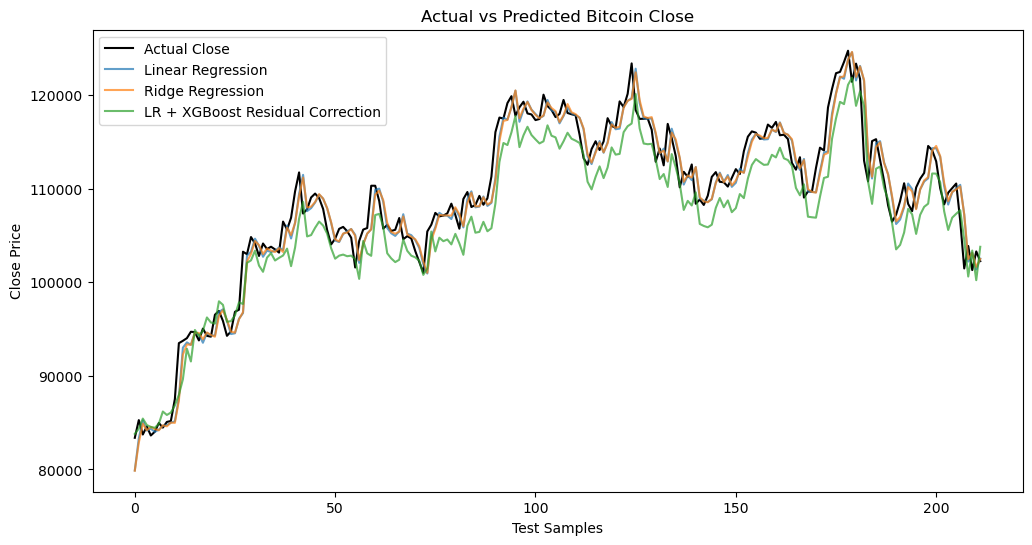

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Close', color='black')
plt.plot(mlr_preds, label='Linear Regression', alpha=0.7)
plt.plot(ridge_preds, label='Ridge Regression', alpha=0.7)
plt.plot(ridge_corrected_preds, label='LR + XGBoost Residual Correction', alpha=0.7)
#plt.plot(rf_preds, label='Random Forest', alpha=0.7)
#plt.plot(xgb_preds, label='XGBoost', alpha=0.7)
plt.title("Actual vs Predicted Bitcoin Close")
plt.xlabel("Test Samples")
plt.ylabel("Close Price")
plt.legend()
plt.show()

c:\Users\baile\anaconda3\envs\crypto_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|===================| 209/212 [00:49<00:00]        

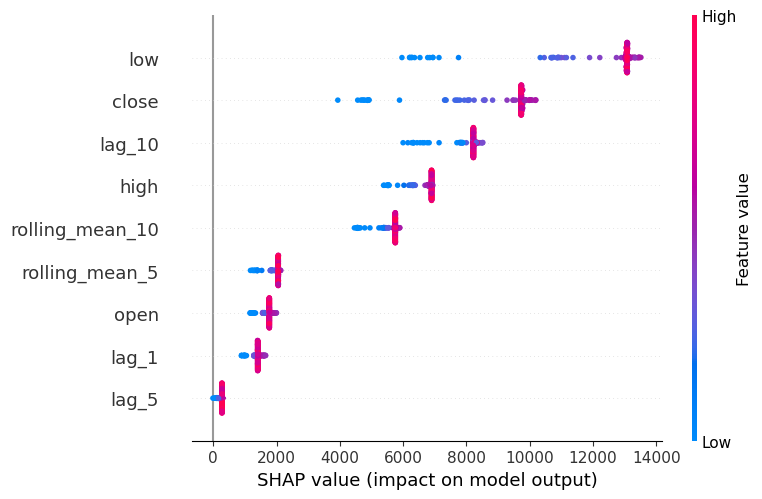

In [27]:
import shap

explainer = shap.Explainer(rf_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, features=X_test, feature_names=selected_features)